In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.tomo import R, RT
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
from holotomocupy.utils import *
import holotomocupy.chunking as chunking


%matplotlib inline

chunking.global_chunk = 20

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 12e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad


## Read data

In [3]:
data00 = np.zeros([ntheta, npos, n, n], dtype='float32')

for k in range(npos):
    data00[:, k] = read_tiff(f'data/data_{n}_{k}.tiff')[:ntheta]
code = np.load('data/code.npy')
shifts_code = np.load('data/shifts_code.npy')[:, :npos]

# Construct operators


#### Forward holo: $d=\mathcal{G}_{z}\left(\mathcal{G}_{z'}(q(\mathcal{S}_{s_{j}}c))\psi\right)$,
#### Adjoint holo: $\psi=\sum_j\left((\mathcal{G}_{z_j'}(q\mathcal{S}_{s'_{kj}}c))^*\mathcal{G}^H_{z}d\right)$.




In [4]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    
    data = cp.zeros([psi.shape[0],npos,n,n],dtype='complex64')
    for i in range(npos):        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        # code shift for each acquisition        
        coder = cp.tile(code,[psi.shape[0],1,1])
        coder = S(coder, shifts_code[:,i])    
        
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]
        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        
        psir = psi.copy()
                
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)

@gpu_batch
def _adj_holo(data, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])

        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        # code shift for each acquisition        
        coder = cp.tile(code,[psi.shape[0],1,1])

        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])

        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # object shift for each acquisition
        psi += psir
    return psi

def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, code, prb)

# adjoint test
data = data00.copy()
arr1 = np.pad(np.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')
prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = fwd_holo(arr3, prb1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(arr4*np.conj(arr4))/npos}==\n{np.sum(arr4*np.conj(arr2))}')

arr1=arr1.swapaxes(0,1)
a = RT(arr1,theta,ne//2)
b = R(a,theta,ne//2)
c = RT(b,theta,ne//2)
print(f'{np.sum(arr1*np.conj(b))}==\n{np.sum(a*np.conj(a))}')
print(f'{np.sum(a*np.conj(a))}==\n{np.sum(a*np.conj(c))/ntheta/ne}')


(22267118-0.04200904816389084j)==
(22267112-5.827087807119824e-05j)
(22349706-1.6363463146262802e-05j)==
(21998082+0.03220176696777344j)
(1043532546048+44066.15625j)==
(1043532283904-1.602410078048706j)
(1043532283904-1.602410078048706j)==
(1058090079573.3334+50375.88888888889j)


### Propagate the code to the detector and divide all data by it

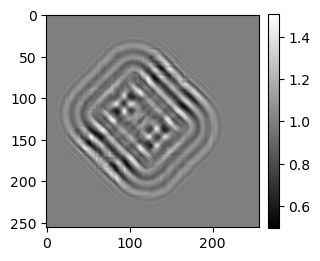

In [5]:

psi = np.ones([ntheta,ne,ne],dtype='complex64')
prb = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
d = np.abs(fwd_holo(psi,prb))**2

rdata = data00/d
mshow(rdata[0,0])

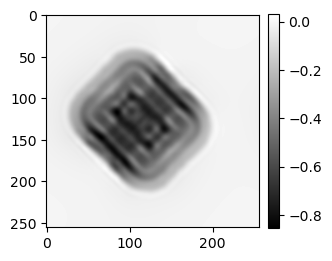

In [6]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  150, 1e-12))
mshow(np.angle(recMultiPaganin[0]))

#### Exponential and logarithm functions for the Transmittance function

In [7]:

def exptomo(psi):
    """Exp representation of projections, exp(i\psi\pi/\lambda)"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength)

def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    res = -1j * wavelength / (2*cp.pi) * res / voxelsize
    return res


#### Main reconstruction. $\left\||\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)e^{\frac{2\pi i}{\lambda}\mathcal{R}u})|-\sqrt{d}\right\|_2^2\to min$

# ADMM

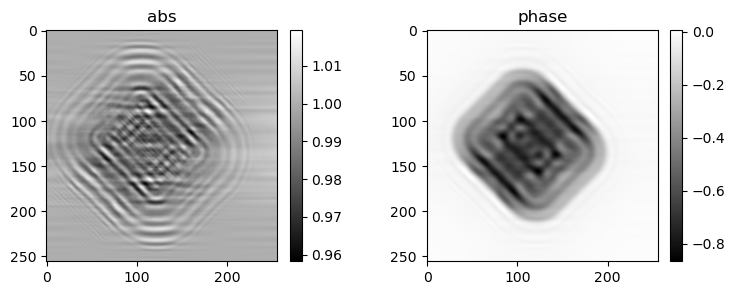

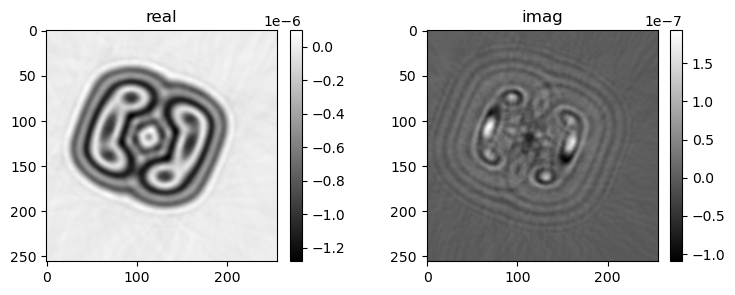

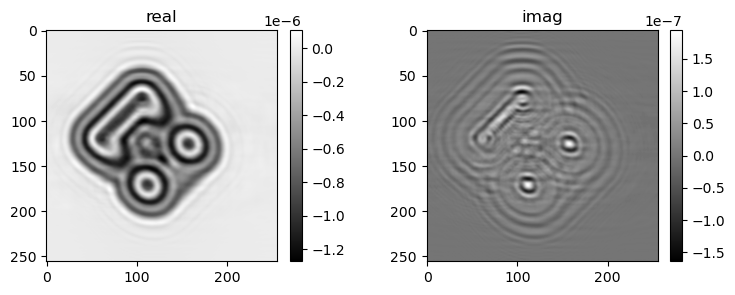

0) Fidelity: 1.8740e+03
4) Fidelity: 6.4386e+02


KeyboardInterrupt: 

In [8]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo_ext(data, init_psi, prb, pars):
    
    """Conjugate gradients method for holography"""
    # minimization functional    
    @gpu_batch
    def _minf(fpsi,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(cp.abs(fpsi[k])-data[k])**2        
        return res
    
    def minf(fpsi):
        res = np.sum(_minf(fpsi,data))        
        return res    
    
    psi = init_psi.copy()

    for i in range(pars['hiter']):
        fpsi = fwd_holo(psi,prb)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb)/npos
        
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d,prb)
        gamma = line_search(minf, pars['gammapsi'], fpsi, fd)
        psi += gamma*d
        
    return psi

def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional    
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    center_pad = center+ne//4
    for i in range(pars['titer']):
        fu = R(u,theta,center_pad)
        grad = RT(fu-data,theta,center_pad)/np.float32(np.prod(data.shape[1:]))
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)

        grad0 = grad
        fd = R(d, theta, center_pad)
        gamma = line_search(minf, pars['gammau'], fu, fd)
        u = linear(u,d,1,gamma)         
    return u

def reproject(data, psi, prb, u, pars):
    @gpu_batch
    def _minf(fpsi,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(cp.abs(fpsi[k])-data[k])**2                    
        return res
    
    def minf(fpsi):
        res = np.sum(_minf(fpsi,data))        
        return res 
    
    data = np.sqrt(data)
    
    for m in range(pars['niter']):
        # solve holography
        psi = cg_holo_ext(data, psi, prb, pars)
        # solve tomography        
        xi = logtomo(psi)        
        xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        xi = xi.swapaxes(0,1)
        u = cg_tomo(xi, u, pars)        
        # reproject
        Ru = R(u,theta,center+ne//4)[:,:,ne//4:-ne//4].swapaxes(0,1)
        psi = exptomo(Ru)
                
        if m%pars['vis_step']==0:
            mshow_polar(psi[0])
            mshow_complex(u[ne//2,ne//4:-ne//4,ne//4:-ne//4])            
            mshow_complex(u[:,ne//2+ne//4+2,ne//4:-ne//4])            
                    
        if m%pars['err_step']==0:                        
            fpsi = fwd_holo(psi,prb)
            err = minf(fpsi)
            print(f"{m}) Fidelity: {err:.4e}")
        
    return u, psi

# Initial guess based on the multipaganin's reconsturction
# gpu processing by chunks
# psirec = np.array(recMultiPaganin).copy()
# urec = np.zeros([ne,3*ne//2,3*ne//2],dtype='complex64')
# data = data00.copy()

# fully on GPU
psirec = cp.array(recMultiPaganin)
data = cp.array(data00)
urec = cp.zeros([ne,3*n//2,3*n//2],dtype='complex64')

# tomographic reconstruction from multipaganin's projections
xi = logtomo(psirec).swapaxes(0,1)
xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
pars = {'titer':65, 'gammau':0.5}
urec = cg_tomo(xi,urec,pars)

pars = {'niter': 2000, 'titer': 4, 'hiter':4, 'err_step': 4, 'vis_step': 16, 'gammapsi': 0.5, 'gammau': 0.5}
urec, psirec = reproject(data, psirec, prb, urec, pars)


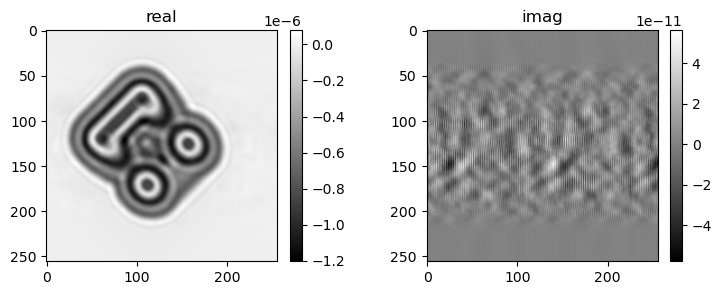

In [ ]:
mshow_complex(urec[:,urec.shape[1]//2+2,ne//4:-ne//4])